In [1]:
from __future__ import print_function, division
from builtins import range
import os
import requests
import zipfile
import numpy as np
import pandas as pd
from scipy.misc.pilutil import imread, imsave, imresize
from glob import glob
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

In [2]:
def get_mnist(limit=None):
    if not os.path.exists('Dataset'):
        print("You must create a folder called large_files adjacent to the class folder first.")
    if not os.path.exists('Dataset/train.csv'):
        print("Looks like you haven't downloaded the data or it's not in the right spot.")
        print("Please get train.csv from https://www.kaggle.com/c/digit-recognizer")
        print("and place it in the large_files folder.")

    print("Reading in and transforming data...")
    df = pd.read_csv('Dataset/train.csv')
    data = df.values
    # np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    X, Y = shuffle(X, Y)
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

In [14]:
class Autoencoder:
    def __init__(self, D, M):
        #  represents the batch of training data
        self.X = T.matrix('X')
        
        # input --> hidden
        self.W = theano.shared(np.random.randn(D, M) * np.sqrt(2.0 / M))
        self.b = theano.shared(np.zeros(M))
        
        # hidden -- > output
        self.V = theano.shared(np.random.randn(M, D) * np.sqrt(2.0 / D))
        self.c = theano.shared(np.zeros(D))
        
        # construct the reconstruction
        self.Z = T.nnet.relu(self.X.dot(self.W) + self.b)
        self.X_hat = T.nnet.sigmoid(self.Z.dot(self.V) + self.c)
        
        # compute the cost
        self.cost = T.sum(
            T.nnet.binary_crossentropy(
                output=self.X_hat,
                target= self.X,
            )
        )
        
        # define the updates
        params = [self.W, self.b, self.V, self.c]
        grads = T.grad(self.cost, params)
        
        #rmsprop
        decay = 0.9
        learning_rate = 0.001
        
        # for rmsprop
        cache = [theano.shared(np.ones_like(p.get_value())) for p in params]
        new_cache = [decay*c + (1-decay)*g*g for p, c, g in zip(params, cache, grads)]
        
        updates = [ (c, new_c) for c, new_c in zip(cache, new_cache)] + [(p, p - learning_rate*g/T.sqrt(new_c + 1e-10)) for p, new_c, g in zip(params, new_cache, grads)]
        
        # define callable function
        self.train_op = theano.function(inputs=[self.X], outputs=self.cost, updates=updates)
        
        self.predict = theano.function(inputs=[self.X], outputs= self.X_hat)
        
    def fit(self, X, epoch=30, batch_sz=64):
        costs = []
        n_batches = len(X)  // batch_sz
        print("n_batches: ", n_batches)
        for i in range(epoch):
            print("epoch:", i)
            np.random.shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j+1)*batch_sz]
                c = self.train_op(batch)
                c /= batch_sz
                costs.append(c)
                if j % 100 == 0:
                    print("iter: %d, cost: %.3f" % (j,c))
        plt.plot(costs)
        plt.show()
        

Reading in and transforming data...
n_batches:  656
epoch: 0
iter: 0, cost: 566.217
iter: 100, cost: 109.923
iter: 200, cost: 83.428
iter: 300, cost: 77.497
iter: 400, cost: 75.451
iter: 500, cost: 69.598
iter: 600, cost: 69.542
epoch: 1
iter: 0, cost: 64.434
iter: 100, cost: 61.413
iter: 200, cost: 63.741
iter: 300, cost: 63.032
iter: 400, cost: 57.142
iter: 500, cost: 57.739
iter: 600, cost: 57.276
epoch: 2
iter: 0, cost: 60.699
iter: 100, cost: 55.001
iter: 200, cost: 57.670
iter: 300, cost: 59.936
iter: 400, cost: 58.206
iter: 500, cost: 52.978
iter: 600, cost: 57.330
epoch: 3
iter: 0, cost: 56.613
iter: 100, cost: 55.818
iter: 200, cost: 52.816
iter: 300, cost: 54.848
iter: 400, cost: 54.571
iter: 500, cost: 52.430
iter: 600, cost: 56.041
epoch: 4
iter: 0, cost: 55.722
iter: 100, cost: 55.677
iter: 200, cost: 55.070
iter: 300, cost: 56.917
iter: 400, cost: 55.907
iter: 500, cost: 57.630
iter: 600, cost: 54.217
epoch: 5
iter: 0, cost: 53.146
iter: 100, cost: 54.717
iter: 200, cost:

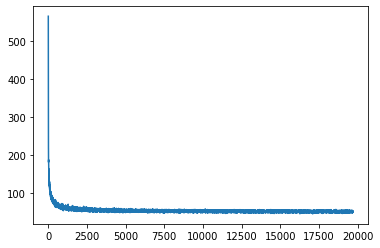

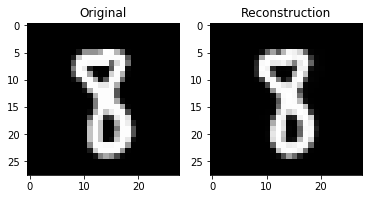

In [15]:
def main():
    X, Y = get_mnist()
    
    model = Autoencoder(784, 300)
    model.fit(X)
    
    # plot reconstrunction
    i = np.random.choice(len(X))
    x = X[i]
    im = model.predict([x]).reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(im, cmap='gray')
    plt.title("Reconstruction")
    plt.show()
    
if __name__ == '__main__':
    main()